In [1]:
import cv2
from skimage.filters import gabor_kernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from time import time, sleep
xPixel = 48  
yPixel = 48

In [2]:
# Directory paths
train_dir = os.path.expanduser('../raw_data/fer2013/train')
test_dir = os.path.expanduser('../raw_data/fer2013/test')

# Define a function to load the balanced data
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                labels.append(label)
    return images, labels

# Load training and testing images
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)


print(f"Loaded {len(train_images)} training images.")
print(f"Loaded {len(test_images)} testing images.")


Loaded 28709 training images.
Loaded 7178 testing images.


In [3]:
# Check the train and test data
print({x: train_labels.count(x) for x in set(train_labels)})
print(np.array(train_images).shape)

print({x: test_labels.count(x) for x in set(test_labels)})
print(np.array(test_images).shape)

{'neutral': 4965, 'surprise': 3171, 'fear': 4097, 'sad': 4830, 'disgust': 436, 'angry': 3995, 'happy': 7215}
(28709, 48, 48)
{'neutral': 1233, 'surprise': 831, 'fear': 1024, 'sad': 1247, 'disgust': 111, 'angry': 958, 'happy': 1774}
(7178, 48, 48)


In [4]:
# set up X, y of train and test
train_Class = np.array(train_labels)
train_images = np.array(train_images)

test_Class = np.array(test_labels)
test_images = np.array(test_images)

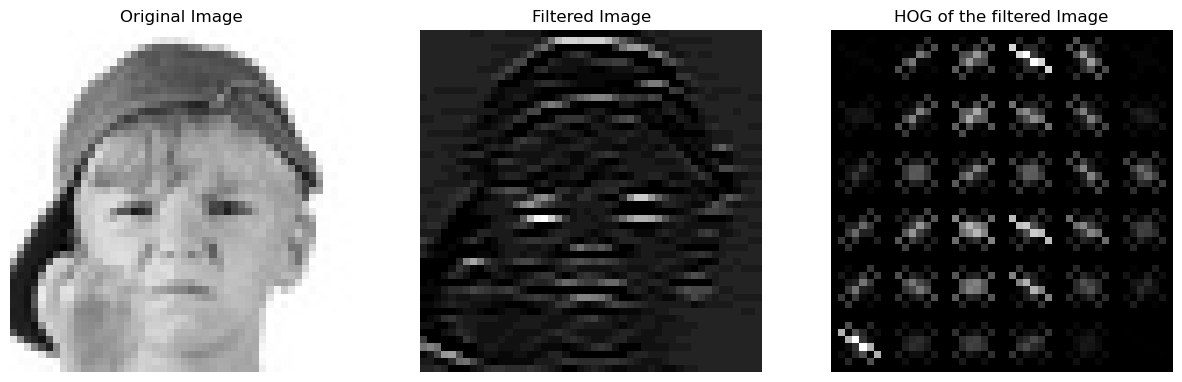

In [41]:
# an illstruation of Gabor filter+HOG
image = train_images[78]
kernel = np.real(gabor_kernel(frequency=0.5, 
                              theta=2/4*np.pi,
                              sigma_x=1, sigma_y=1))

filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)

HOG_features, HOG_image = hog(filtered_image, 
                              orientations=4, 
                              pixels_per_cell=(8, 8),
                              cells_per_block=(6, 6), 
                              visualize=True)


# Display the original and a filtered image side by side
plt.figure(figsize=(15, 5))  # Adjust figure size if needed

# Original image
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Filtered image (select one from filtered_images, e.g., the first one)
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(filtered_image, cmap='gray')  # Display the first filtered image
plt.title('Filtered Image')
plt.axis('off')

# Filtered image (select one from filtered_images, e.g., the first one)
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
plt.imshow(HOG_image, cmap='gray')  # Display the first filtered image
plt.title('HOG of the filtered Image')
plt.axis('off')

plt.show()

### Method 1: Apply a coarse Gabor and HOG

In [13]:
# define the function to apply gabor filter and HOG features extraction at the same time
def Gabor_HOG(image):
    kernel = np.real(gabor_kernel(frequency=0.25, 
                              theta=2/4*np.pi,
                              sigma_x=2, sigma_y=2))

    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)

    Gabor_HOG_features = hog(filtered_image, 
                              orientations=4, 
                              pixels_per_cell=(8, 8),
                              cells_per_block=(6, 6), 
                              visualize=False)
    return Gabor_HOG_features

In [14]:
# Apply the Gabor_HOG function to each image
train_images_Gabor_HOG = []
for i in range(train_images.shape[0]):
    image = train_images[i]
    features = Gabor_HOG(image)
    train_images_Gabor_HOG.append(features)
    
# Convert the list of features to a NumPy array
train_images_Gabor_HOG = np.array(train_images_Gabor_HOG)

print(train_images_Gabor_HOG.shape)  # Print the shape of the resulting feature array


test_images_Gabor_HOG = []
for i in range(test_images.shape[0]):
    image = test_images[i]
    features = Gabor_HOG(image)
    test_images_Gabor_HOG.append(features)
    
# Convert the list of features to a NumPy array
test_images_Gabor_HOG = np.array(test_images_Gabor_HOG)

print(test_images_Gabor_HOG.shape)  # Print the shape of the resulting feature array

(28709, 144)
(7178, 144)


In [47]:
# Assuming you have your data as X and y

def auto_xgboost(
    X,
    y,
    n_estimators=200,
    random_state=2024,
    cv=10
    ):
    # 1. Parameter grid
    param_grid = {
        'max_depth': [5, 10, 20, 50],
        'learning_rate': [0.01, 0.05, 0.1],
        'colsample_bytree': [0.1, 0.2, 0.5]
        # 'min_child_weight': [1, 2, 5, 10, 20]
        # 'gamma': [0, 0.1],
        # 'subsample': [0.8, 1.0]
    }
    # 2. Create base model
    xgb_model = XGBClassifier(
        objective='multi:softmax',
        n_estimators= n_estimators,
        subsample = 0.4, # randomly sample 30% of the training data for each tree, avoid overfitting
        # use_label_encoder=False,
        eval_metric='merror',
        random_state=random_state,
        n_jobs = 1
    )

    # 3. Setup StratifiedKFold
    skf = StratifiedKFold(
        n_splits=cv,
        shuffle=True,
        random_state=random_state
    )

    # 4. Setup GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1, # use all the CPU cores
        verbose=2  # detailed output monitoring progress updates
    )

    # 5. Scale the features
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. Fit the model
    grid_search.fit(X_scaled, y_encoded)

    # 7. Best model
    best_model = grid_search.best_estimator_
    
    # 8. Best params
    best_par = grid_search.best_params_
    
    # 9. Best CV score
    best_score = grid_search.best_score_

    # 10. Feature importance
    feature_importance = pd.DataFrame({
        'feature': [f'feature_{i}' for i in range(X.shape[1])],
        'importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # compile and return the results
    results = {
        'best_params': best_par,
        'best_score': best_score,
        'best_model': best_model,
        'feature_importance': feature_importance
    }

    return results, grid_search

In [48]:
start_time = time()

XGB_result, grid_search = auto_xgboost(X=train_images_Gabor_HOG, y=train_Class)
  
end_time = time()
print(f"Runtime: {(end_time - start_time)/60} mins")

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Runtime: 118.72640028397242 mins


In [49]:
# loop through and print the results
for key, value in XGB_result.items():
    print(f"{key}: \n {value}")

best_params: 
 {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 20}
best_score: 
 0.44686324982372083
best_model: 
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=1, num_parallel_tree=None, objective='multi:softmax', ...)
feature_importance: 
          feature  importance
113  feature_113    0.011649
106  feature_106    0.009893

In [55]:
start_time = time()

# work on the test data set
# fit with the best model with 5000 trees
scaler = StandardScaler()
scaler.fit(train_images_Gabor_HOG)
train_images_scaled = scaler.transform(train_images_Gabor_HOG)
test_images_scaled = scaler.transform(test_images_Gabor_HOG)

# encode the classes
label_encoder = LabelEncoder()
label_encoder.fit(train_Class)
train_Class_encoded = label_encoder.transform(train_Class)
test_Class_encoded = label_encoder.transform(test_Class)

X_ttrain, X_val, y_ttrain, y_val = train_test_split(train_images_scaled, train_Class_encoded, 
                                                  test_size=0.1, random_state=2024, stratify=train_Class_encoded)
    
    
xgb = XGBClassifier(max_depth=20, learning_rate=0.05,
                       random_state=2024, subsample = 0.5, n_estimators=5000, colsample_bytree=0.5,
                       objective='multi:softmax', eval_metric='merror', early_stopping_rounds=500)
xgb.fit(X_ttrain, y_ttrain, eval_set=[(X_val, y_val)])
# xgb.fit(train_images_scaled, train_Class_encoded)
train_Class_pred = xgb.predict(train_images_scaled)
test_Class_pred = xgb.predict(test_images_scaled)

end_time = time()
print(f"Runtime: {(end_time - start_time)/60} mins")

[0]	validation_0-merror:0.72901
[1]	validation_0-merror:0.69488
[2]	validation_0-merror:0.67503
[3]	validation_0-merror:0.65587
[4]	validation_0-merror:0.64855
[5]	validation_0-merror:0.64786
[6]	validation_0-merror:0.63950
[7]	validation_0-merror:0.63393
[8]	validation_0-merror:0.62905
[9]	validation_0-merror:0.62313
[10]	validation_0-merror:0.62104
[11]	validation_0-merror:0.60989
[12]	validation_0-merror:0.60780
[13]	validation_0-merror:0.60676
[14]	validation_0-merror:0.60745
[15]	validation_0-merror:0.60676
[16]	validation_0-merror:0.60571
[17]	validation_0-merror:0.61372
[18]	validation_0-merror:0.61407
[19]	validation_0-merror:0.61372
[20]	validation_0-merror:0.61442
[21]	validation_0-merror:0.61198
[22]	validation_0-merror:0.60850
[23]	validation_0-merror:0.60641
[24]	validation_0-merror:0.60327
[25]	validation_0-merror:0.60362
[26]	validation_0-merror:0.60780
[27]	validation_0-merror:0.60258
[28]	validation_0-merror:0.60014
[29]	validation_0-merror:0.59840
[30]	validation_0-me

In [56]:
# train accuracy
print(accuracy_score(train_Class_encoded, train_Class_pred))
        
# classification_report
print(classification_report(train_Class_encoded, train_Class_pred))

0.9452436518165035
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3995
           1       1.00      0.92      0.96       436
           2       0.97      0.92      0.94      4097
           3       0.93      0.98      0.95      7215
           4       0.94      0.94      0.94      4965
           5       0.93      0.93      0.93      4830
           6       0.96      0.95      0.96      3171

    accuracy                           0.95     28709
   macro avg       0.96      0.94      0.95     28709
weighted avg       0.95      0.95      0.95     28709



In [57]:
# train accuracy
print(accuracy_score(test_Class_encoded, test_Class_pred))
        
# classification_report
print(classification_report(test_Class_encoded, test_Class_pred))

0.4657286152131513
              precision    recall  f1-score   support

           0       0.42      0.29      0.35       958
           1       0.97      0.28      0.43       111
           2       0.42      0.24      0.31      1024
           3       0.51      0.79      0.62      1774
           4       0.40      0.39      0.39      1233
           5       0.36      0.35      0.35      1247
           6       0.64      0.57      0.60       831

    accuracy                           0.47      7178
   macro avg       0.53      0.42      0.44      7178
weighted avg       0.46      0.47      0.45      7178



### Method 2: Apply a much finer Gabor + HOG + PCA

In [70]:
# a finer gabor filter and HOG features extraction
def Gabor_HOG2(image):
    kernel = np.real(gabor_kernel(frequency=0.25, 
                              theta=2/4*np.pi,
                              sigma_x=1, sigma_y=1))

    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)

    Gabor_HOG_features = hog(filtered_image, 
                              orientations=8, 
                              pixels_per_cell=(4, 4),
                              cells_per_block=(2, 2), 
                              visualize=False)
    return Gabor_HOG_features

In [71]:
# Apply the Gabor_HOG function to each image
train2_images_Gabor_HOG = []
for i in range(train_images.shape[0]):
    image = train_images[i]
    features = Gabor_HOG2(image)
    train2_images_Gabor_HOG.append(features)
    
# Convert the list of features to a NumPy array
train2_images_Gabor_HOG = np.array(train2_images_Gabor_HOG)

print(train2_images_Gabor_HOG.shape)  # Print the shape of the resulting feature array


test2_images_Gabor_HOG = []
for i in range(test_images.shape[0]):
    image = test_images[i]
    features = Gabor_HOG2(image)
    test2_images_Gabor_HOG.append(features)
    
# Convert the list of features to a NumPy array
test2_images_Gabor_HOG = np.array(test2_images_Gabor_HOG)

print(test2_images_Gabor_HOG.shape)  # Print the shape of the resulting feature array

(28709, 3872)
(7178, 3872)


In [73]:
from sklearn.decomposition import PCA
# Standardize the data and PCA
scaler = StandardScaler()
scaler.fit(train2_images_Gabor_HOG)
train2_images_scaled = scaler.transform(train2_images_Gabor_HOG)
test2_images_scaled = scaler.transform(test2_images_Gabor_HOG)

pca = PCA()  # Keep all components initially
principalComponents = pca.fit_transform(train2_images_scaled)

In [76]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Find the index where cumulative variance exceeds 0.80
n_components = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.9]) + 1 

print(f"Number of components to explain 90% variance: {n_components}")

Number of components to explain 90% variance: 865


In [78]:
# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
train2_images_pca = pca.fit_transform(train2_images_scaled)
test2_images_pca = pca.transform(test2_images_scaled)

In [ ]:
start_time = time()

# work on the test data set
# fit with the best model with 5000 trees with earky stop rule

# encode the classes
label_encoder = LabelEncoder()
label_encoder.fit(train_Class)
train_Class_encoded = label_encoder.transform(train_Class)
test_Class_encoded = label_encoder.transform(test_Class)

X_ttrain, X_val, y_ttrain, y_val = train_test_split(train2_images_pca, train_Class_encoded, 
                                                  test_size=0.1, random_state=2024, stratify=train_Class_encoded)
    
    
xgb = XGBClassifier(max_depth=20, learning_rate=0.05,
                       random_state=2024, subsample = 0.5, n_estimators=5000, colsample_bytree=0.1,
                       objective='multi:softmax', eval_metric='merror', early_stopping_rounds=500)
xgb.fit(X_ttrain, y_ttrain, eval_set=[(X_val, y_val)])

train_Class_pred = xgb.predict(train2_images_pca)
test_Class_pred = xgb.predict(test2_images_pca)

end_time = time()
print(f"Runtime: {(end_time - start_time)/60} mins")

[0]	validation_0-merror:0.77429
[1]	validation_0-merror:0.74538
[2]	validation_0-merror:0.72379
[3]	validation_0-merror:0.71578
[4]	validation_0-merror:0.70707
[5]	validation_0-merror:0.70045
[6]	validation_0-merror:0.69140
[7]	validation_0-merror:0.68966
[8]	validation_0-merror:0.68095
[9]	validation_0-merror:0.68652
[10]	validation_0-merror:0.68513
[11]	validation_0-merror:0.68896
[12]	validation_0-merror:0.68722
[13]	validation_0-merror:0.68408
[14]	validation_0-merror:0.67990
[15]	validation_0-merror:0.67990
[16]	validation_0-merror:0.67851
[17]	validation_0-merror:0.67572
[18]	validation_0-merror:0.67154
[19]	validation_0-merror:0.67537
[20]	validation_0-merror:0.67015
[21]	validation_0-merror:0.67259
[22]	validation_0-merror:0.66597
[23]	validation_0-merror:0.66876
[24]	validation_0-merror:0.66841
[25]	validation_0-merror:0.66701
[26]	validation_0-merror:0.66841
[27]	validation_0-merror:0.66980
[28]	validation_0-merror:0.66806
[29]	validation_0-merror:0.67154
[30]	validation_0-me

In [81]:
# train accuracy
print(accuracy_score(train_Class_encoded, train_Class_pred))
        
# classification_report
print(classification_report(train_Class_encoded, train_Class_pred))

0.9442683479048382
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3995
           1       1.00      0.92      0.95       436
           2       0.97      0.92      0.94      4097
           3       0.91      0.98      0.95      7215
           4       0.94      0.94      0.94      4965
           5       0.94      0.93      0.93      4830
           6       0.98      0.95      0.96      3171

    accuracy                           0.94     28709
   macro avg       0.96      0.94      0.95     28709
weighted avg       0.95      0.94      0.94     28709



In [82]:
# train accuracy
print(accuracy_score(test_Class_encoded, test_Class_pred))
        
# classification_report
print(classification_report(test_Class_encoded, test_Class_pred))

0.4667038172192811
              precision    recall  f1-score   support

           0       0.43      0.23      0.30       958
           1       1.00      0.27      0.43       111
           2       0.48      0.23      0.31      1024
           3       0.47      0.84      0.60      1774
           4       0.41      0.43      0.42      1233
           5       0.36      0.32      0.34      1247
           6       0.82      0.53      0.64       831

    accuracy                           0.47      7178
   macro avg       0.57      0.41      0.43      7178
weighted avg       0.48      0.47      0.44      7178



### Method 3: Gaber filter & PCA, stack with HOG & PCA

In [5]:
# define differnet functions to apply gabor filter and HOG features extraction
def Gabor(image):
    kernel = np.real(gabor_kernel(
                    frequency=2, 
                    theta=2/4*np.pi,
                    sigma_x=1, sigma_y=1))

    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
    return filtered_image

def HOG(image):
    HOG_features = hog(image, 
                        orientations=6, 
                        pixels_per_cell=(8, 8),
                        cells_per_block=(4, 4), 
                        visualize=False)
                        # channel_axis=-1
    return HOG_features

In [6]:
# Apply the Gabor and HOG respectively to each image
train_images_Gabor = []
for i in range(train_images.shape[0]):
    image = train_images[i]
    filtered_image = Gabor(image)
    train_images_Gabor.append(filtered_image)
train_images_Gabor = np.array(train_images_Gabor)
train_images_Gabor = train_images_Gabor.reshape((train_images_Gabor.shape[0],-1))
print(train_images_Gabor.shape)  # Print the shape of the resulting feature array


test_images_Gabor = []
for i in range(test_images.shape[0]):
    image = test_images[i]
    filtered_image = Gabor(image)
    test_images_Gabor.append(filtered_image)
test_images_Gabor = np.array(test_images_Gabor)
test_images_Gabor = test_images_Gabor.reshape((test_images_Gabor.shape[0],-1))
print(test_images_Gabor.shape)  # Print the shape of the resulting feature array


train_images_HOG = []
for i in range(train_images.shape[0]):
    image = train_images[i]
    features = HOG(image)
    train_images_HOG.append(features)
train_images_HOG = np.array(train_images_HOG)
print(train_images_HOG.shape)  # Print the shape of the resulting feature array

test_images_HOG = []
for i in range(test_images.shape[0]):
    image = test_images[i]
    features = HOG(image)
    test_images_HOG.append(features)
test_images_HOG = np.array(test_images_HOG)
print(test_images_HOG.shape)  # Print the shape of the resulting feature array


(28709, 2304)
(7178, 2304)
(28709, 864)
(7178, 864)


In [7]:
# Apply PCA to Gabor data
from sklearn.decomposition import PCA
# Standardize the data and PCA
scaler = StandardScaler()
scaler.fit(train_images_Gabor)
train_images_Gabor_scaled = scaler.transform(train_images_Gabor)
test_images_Gabor_scaled = scaler.transform(test_images_Gabor)

pca = PCA()  # Keep all components initially
principalComponents = pca.fit_transform(train_images_Gabor_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Find the index where cumulative variance exceeds 0.80
n_components = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.9]) + 1 

print(f"Number of components to explain 90% variance: {n_components}")

# do the PCA transformation to the Gabor data
pca = PCA(n_components=n_components)
train_images_Gabor_pca = pca.fit_transform(train_images_Gabor_scaled)
test_images_Gabor_pca = pca.transform(test_images_Gabor_scaled)
print(train_images_Gabor_pca.shape)
print(test_images_Gabor_pca.shape)

Number of components to explain 90% variance: 37
(28709, 37)
(7178, 37)


In [8]:
# Apply PCA to HOG features
# Standardize the data and PCA
scaler = StandardScaler()
scaler.fit(train_images_HOG)
train_images_HOG_scaled = scaler.transform(train_images_HOG)
test_images_HOG_scaled = scaler.transform(test_images_HOG)

pca = PCA()  # Keep all components initially
principalComponents = pca.fit_transform(train_images_HOG_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Find the index where cumulative variance exceeds 0.80
n_components = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.9]) + 1 

print(f"Number of components to explain 90% variance: {n_components}")

# do the PCA transformation to the Gabor data
pca = PCA(n_components=n_components)
train_images_HOG_pca = pca.fit_transform(train_images_HOG_scaled)
test_images_HOG_pca = pca.transform(test_images_HOG_scaled)
print(train_images_HOG_pca.shape)
print(test_images_HOG_pca.shape)

Number of components to explain 90% variance: 131
(28709, 131)
(7178, 131)


In [9]:
# Combine Gabar and HOG data
train_images_pca = np.concatenate((train_images_Gabor_pca, train_images_HOG_pca), axis=1)
test_images_pca = np.concatenate((test_images_Gabor_pca, test_images_HOG_pca), axis=1)
print(train_images_pca.shape)
print(test_images_pca.shape)

(28709, 168)
(7178, 168)


In [85]:
# Assuming you have your data as X and y

def auto_xgboost(
    X,
    y,
    n_estimators=200,
    random_state=2024,
    cv=10
    ):
    # 1. Parameter grid
    param_grid = {
        'max_depth': [5, 10, 20, 30],
        'learning_rate': [0.01, 0.05, 0.1],
        'colsample_bytree': [0.1, 0.3, 0.5]
        # 'min_child_weight': [1, 2, 5, 10, 20]
        # 'gamma': [0, 0.1],
        # 'subsample': [0.8, 1.0]
    }
    # 2. Create base model
    xgb_model = XGBClassifier(
        objective='multi:softmax',
        n_estimators= n_estimators,
        subsample = 0.3, # randomly sample 30% of the training data for each tree, avoid overfitting
        # use_label_encoder=False,
        eval_metric='merror',
        random_state=random_state,
        n_jobs = 1
    )

    # 3. Setup StratifiedKFold
    skf = StratifiedKFold(
        n_splits=cv,
        shuffle=True,
        random_state=random_state
    )

    # 4. Setup GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1, # use all the CPU cores
        verbose=2  # detailed output monitoring progress updates
    )

    # 5. Scale the features
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. Fit the model
    grid_search.fit(X_scaled, y_encoded)

    # 7. Best model
    best_model = grid_search.best_estimator_
    
    # 8. Best params
    best_par = grid_search.best_params_
    
    # 9. Best CV score
    best_score = grid_search.best_score_

    # 10. Feature importance
    feature_importance = pd.DataFrame({
        'feature': [f'feature_{i}' for i in range(X.shape[1])],
        'importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # compile and return the results
    results = {
        'best_params': best_par,
        'best_score': best_score,
        'best_model': best_model,
        'feature_importance': feature_importance
    }

    return results, grid_search

In [87]:
start_time = time()

XGB_result, grid_search = auto_xgboost(X=train_images_pca, y=train_Class)
  
end_time = time()
print(f"Runtime: {(end_time - start_time)/60} mins")

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Runtime: 108.1307745218277 mins


In [88]:
# loop through and print the results
for key, value in XGB_result.items():
    print(f"{key}: \n {value}")

best_params: 
 {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 10}
best_score: 
 0.5069137488060953
best_model: 
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=1, num_parallel_tree=None, objective='multi:softmax', ...)
feature_importance: 
          feature  importance
47    feature_47    0.013484
37    feature_37    0.009227


In [11]:
start_time = time()

# work on the test data set
# fit with the best model with 5000 trees

# encode the classes
label_encoder = LabelEncoder()
label_encoder.fit(train_Class)
train_Class_encoded = label_encoder.transform(train_Class)
test_Class_encoded = label_encoder.transform(test_Class)
# fit with the best model with 5000 trees

X_ttrain, X_val, y_ttrain, y_val = train_test_split(train_images_pca, train_Class_encoded, 
                                                  test_size=0.1, random_state=2024, stratify=train_Class_encoded)
    
    
xgb = XGBClassifier(max_depth=10, learning_rate=0.05,
                       random_state=2024, subsample = 0.3, n_estimators=5000, colsample_bytree=0.5,
                       objective='multi:softmax', eval_metric='merror', early_stopping_rounds=500)
xgb.fit(X_ttrain, y_ttrain, eval_set=[(X_val, y_val)])
train_Class_pred = xgb.predict(train_images_pca)
test_Class_pred = xgb.predict(test_images_pca)

end_time = time()
print(f"Runtime: {(end_time - start_time)/60} mins")

[0]	validation_0-merror:0.73180
[1]	validation_0-merror:0.70115
[2]	validation_0-merror:0.66876
[3]	validation_0-merror:0.66318
[4]	validation_0-merror:0.64263
[5]	validation_0-merror:0.63706
[6]	validation_0-merror:0.62696
[7]	validation_0-merror:0.61755
[8]	validation_0-merror:0.61163
[9]	validation_0-merror:0.60954
[10]	validation_0-merror:0.60258
[11]	validation_0-merror:0.59526
[12]	validation_0-merror:0.59526
[13]	validation_0-merror:0.59039
[14]	validation_0-merror:0.59143
[15]	validation_0-merror:0.58621
[16]	validation_0-merror:0.58307
[17]	validation_0-merror:0.58063
[18]	validation_0-merror:0.57750
[19]	validation_0-merror:0.56949
[20]	validation_0-merror:0.57018
[21]	validation_0-merror:0.56949
[22]	validation_0-merror:0.57367
[23]	validation_0-merror:0.57158
[24]	validation_0-merror:0.57053
[25]	validation_0-merror:0.56809
[26]	validation_0-merror:0.56635
[27]	validation_0-merror:0.56670
[28]	validation_0-merror:0.56392
[29]	validation_0-merror:0.56148
[30]	validation_0-me

In [ ]:
# train accuracy
print(accuracy_score(train_Class_encoded, train_Class_pred))
        
# classification_report
print(classification_report(train_Class_encoded, train_Class_pred))

0.9528022571319098
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      3995
           1       1.00      0.92      0.96       436
           2       0.96      0.93      0.95      4097
           3       0.95      0.98      0.96      7215
           4       0.95      0.95      0.95      4965
           5       0.94      0.94      0.94      4830
           6       0.97      0.96      0.97      3171

    accuracy                           0.95     28709
   macro avg       0.96      0.95      0.95     28709
weighted avg       0.95      0.95      0.95     28709



In [ ]:
# train accuracy
print(accuracy_score(test_Class_encoded, test_Class_pred))
        
# classification_report
print(classification_report(test_Class_encoded, test_Class_pred))

0.5380328782390638
              precision    recall  f1-score   support

           0       0.46      0.34      0.39       958
           1       0.95      0.32      0.48       111
           2       0.49      0.35      0.41      1024
           3       0.61      0.80      0.69      1774
           4       0.46      0.53      0.49      1233
           5       0.42      0.41      0.42      1247
           6       0.76      0.66      0.71       831

    accuracy                           0.54      7178
   macro avg       0.59      0.49      0.51      7178
weighted avg       0.54      0.54      0.53      7178



In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [25]:
# comfusion matrix
test_Class_pred = label_encoder.inverse_transform(test_Class_pred) 
cm = confusion_matrix(test_Class, test_Class_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

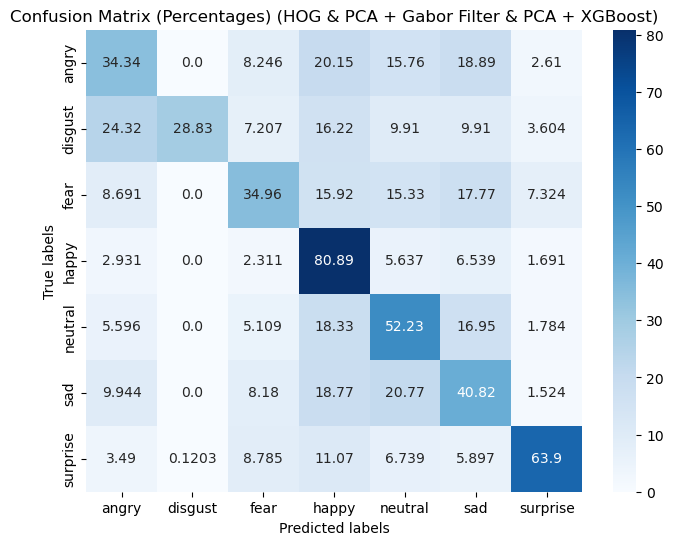

In [37]:
# Create the heatmap with annotations as percentages
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized*100, annot=True, fmt='.4', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)  # Format as percentages with 2 decimal places
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Percentages) (HOG & PCA + Gabor Filter & PCA + XGBoost)')
plt.show()